# Monochromator calibration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson, trapezoid

### Read in and clean the data

In [2]:
path = r"C:\\Users\\Brock\\Documents\\Git\\Research\\CCDs\\Monochromator Calibration\\"

In [3]:
for i in range(0, 18):
    data = np.loadtxt(path + 'Home_{:.0f}.txt'.format(i), skiprows = 14)
    np.savetxt(path + 'Home_{:.0f}.csv'.format(i), data, delimiter=",", fmt="%.4f",)

In [4]:
for i in range(250, 700, 50):
    data = np.loadtxt(path + '{:.0f}.txt'.format(i), skiprows = 2)
    np.savetxt(path + '{:.0f}.csv'.format(i), data, delimiter=",", fmt="%.4f",)

### Read in single home calibration

In [5]:
home_spectrum = pd.read_csv(path + 'Home_1.csv', header=None) 

In [6]:
home_wavelength = np.array(home_spectrum[0])
home_wavelength_err = np.append(np.diff(home_wavelength), np.diff(home_wavelength)[-1])/2
home_intensity = np.array(home_spectrum[1])
home_intensity_err = np.sqrt(abs(home_intensity))

In [7]:
def gauss(x, m, s, a, b):
    return a * np.exp( - (x - m)**2 / (2 * s**2)) + b

In [8]:
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=30)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

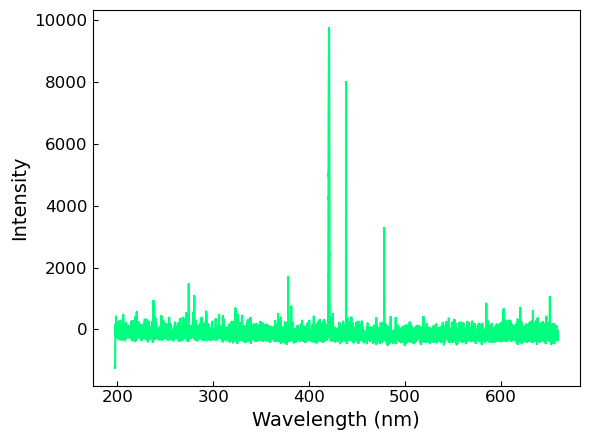

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight') 

ax.errorbar(home_wavelength, home_intensity, xerr=home_wavelength_err, yerr=home_intensity_err, color='springgreen')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
ax.tick_params(axis='both', direction='in', which='both')
fig.tight_layout()

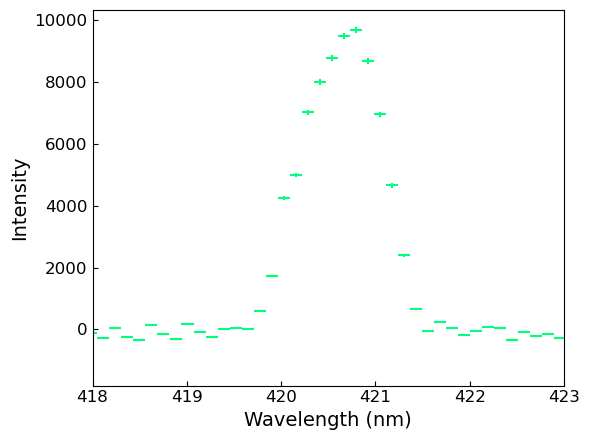

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight') 

ax.errorbar(home_wavelength, home_intensity, xerr=home_wavelength_err, yerr=home_intensity_err, color='springgreen', ls='')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(418, 423)
fig.tight_layout()

### Fit a Gaussian to the peak

In [11]:
popt, pcov = curve_fit(gauss, home_wavelength, home_intensity, p0 = (420, 2, 10000, 0), sigma=home_intensity_err, absolute_sigma=True)
cerr = np.sqrt(np.diag(pcov))

In [12]:
x = np.linspace(-200, 1000, 100000)

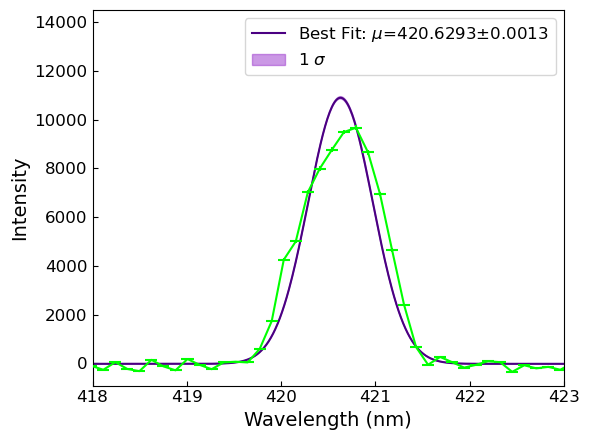

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight') 

ax.errorbar(home_wavelength, home_intensity, xerr=home_wavelength_err, yerr=home_intensity_err, color='lime', ls='-', zorder=10)
ax.plot(x, gauss(x, *popt), color='indigo', label='Best Fit: $\mu$={:.4f}$\pm${:.4f}'.format(popt[0], cerr[0]))
# ax.plot(x, gauss(x, *popt), color='orangered', label='Best Fit: $\mu$={:.3f}$\pm${:.3f}, $\sigma$={:.3f}$\pm${:.3f}\n$A$={:.3f}$\pm${:.3f}, $B$={:.3f}$\pm${:.3f}'.format(popt[0], cerr[0], popt[1], cerr[1], popt[2], cerr[2], popt[3], cerr[3]))
ax.fill_between(x, gauss(x, *(popt + cerr)), gauss(x, *(popt - cerr)), color='darkorchid', alpha=0.5, label='1 $\sigma$')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(418, 423)
ax.set_ylim(0.75*home_intensity.min(), 1.5*home_intensity.max())
ax.legend(loc='best')
fig.tight_layout()

### Calculate Centroid

In [14]:
def centroid(x, y):
    A = trapezoid(y = y, x = x)
    xc = trapezoid(y = y*x, x = x) / A
    return xc

In [15]:
test_ind = (home_wavelength < 423) & (home_wavelength > 418)

home_centroid = centroid(home_wavelength[test_ind], home_intensity[test_ind])
home_centroid_err = 0.1

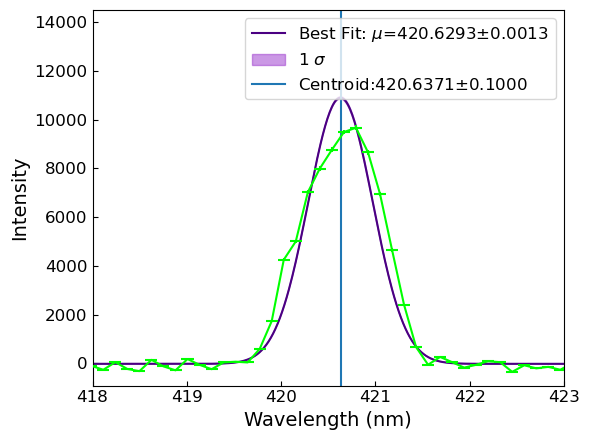

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight') 

ax.errorbar(home_wavelength, home_intensity, xerr=home_wavelength_err, yerr=home_intensity_err, color='lime', ls='-', zorder=10)
ax.plot(x, gauss(x, *popt), color='indigo', label='Best Fit: $\mu$={:.4f}$\pm${:.4f}'.format(popt[0], cerr[0]))
# ax.plot(x, gauss(x, *popt), color='orangered', label='Best Fit: $\mu$={:.3f}$\pm${:.3f}, $\sigma$={:.3f}$\pm${:.3f}\n$A$={:.3f}$\pm${:.3f}, $B$={:.3f}$\pm${:.3f}'.format(popt[0], cerr[0], popt[1], cerr[1], popt[2], cerr[2], popt[3], cerr[3]))
ax.fill_between(x, gauss(x, *(popt + cerr)), gauss(x, *(popt - cerr)), color='darkorchid', alpha=0.5, label='1 $\sigma$')
ax.axvline(home_centroid, label='Centroid:{:.4f}$\pm${:.4f}'.format(home_centroid, home_centroid_err))

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(418, 423)
ax.set_ylim(0.75*home_intensity.min(), 1.5*home_intensity.max())
ax.legend(loc='best')
fig.tight_layout()

### Read in all home wavelengths

In [17]:
stacked_intensity = home_intensity
for i in range(1, 18):
    foo = pd.read_csv(path + 'Home_{:.0f}.csv'.format(i), header=None)
    bar = np.array(foo[1])
    stacked_intensity = stacked_intensity + bar
stacked_intensity_err = np.sqrt(abs(stacked_intensity))

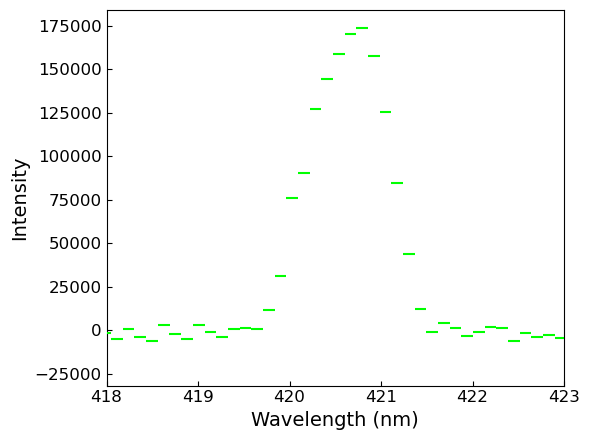

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight') 

ax.errorbar(home_wavelength, stacked_intensity, xerr=home_wavelength_err, yerr=stacked_intensity_err, color='lime', ls='', zorder=10)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(418, 423)
fig.tight_layout()

In [19]:
stack_popt, stack_pcov = curve_fit(gauss, home_wavelength, stacked_intensity, p0 = (420, 2, 175000, 0), sigma=stacked_intensity_err, absolute_sigma=True)
stack_cerr = np.sqrt(np.diag(stack_pcov))

In [20]:
stack_ind = (home_wavelength < 423) & (home_wavelength > 418)

stack_centroid = centroid(home_wavelength[stack_ind], stacked_intensity[stack_ind])
stack_centroid_err = 0.1

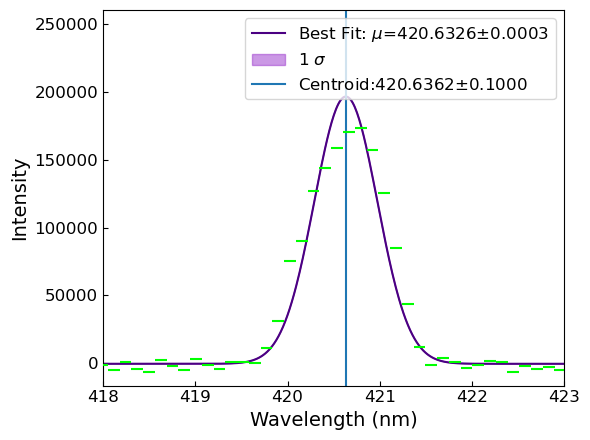

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight') 

ax.errorbar(home_wavelength, stacked_intensity, xerr=home_wavelength_err, yerr=stacked_intensity_err, color='lime', ls='', zorder=10)
ax.plot(x, gauss(x, *stack_popt), color='indigo', label='Best Fit: $\mu$={:.4f}$\pm${:.4f}'.format(stack_popt[0], stack_cerr[0]))
# ax.plot(x, gauss(x, *stack_popt), color='orangered', label='Best Fit: $\mu$={:.3f}$\pm${:.3f}, $\sigma$={:.3f}$\pm${:.3f}\n$A$={:.3f}$\pm${:.3f}, $B$={:.3f}$\pm${:.3f}'.format(stack_popt[0], stack_cerr[0], stack_popt[1], stack_cerr[1], stack_popt[2], stack_cerr[2], stack_popt[3], stack_cerr[3]))
ax.fill_between(x, gauss(x, *(stack_popt + stack_cerr)), gauss(x, *(stack_popt - stack_cerr)), color='darkorchid', alpha=0.5, label='1 $\sigma$')
ax.axvline(home_centroid, label='Centroid:{:.4f}$\pm${:.4f}'.format(stack_centroid, stack_centroid_err))

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(418, 423)
ax.set_ylim(0.75*stacked_intensity.min(), 1.5*stacked_intensity.max())
ax.legend(loc='best')
fig.tight_layout()

In [22]:
best_home_wavelength = stack_popt[0]

The best fit home wavelength is approximately

$$420.633~\rm{nm}$$

## Now fit all of the individual wavelength calibration files

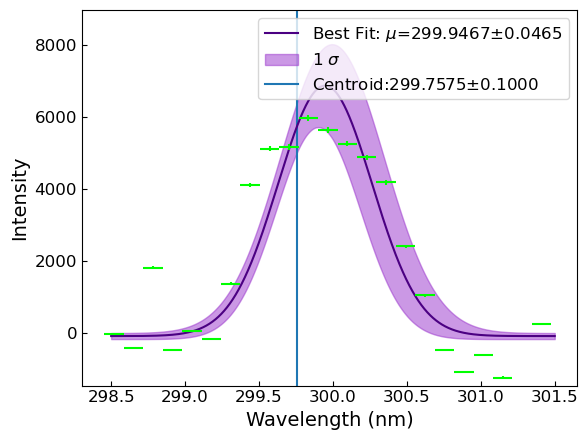

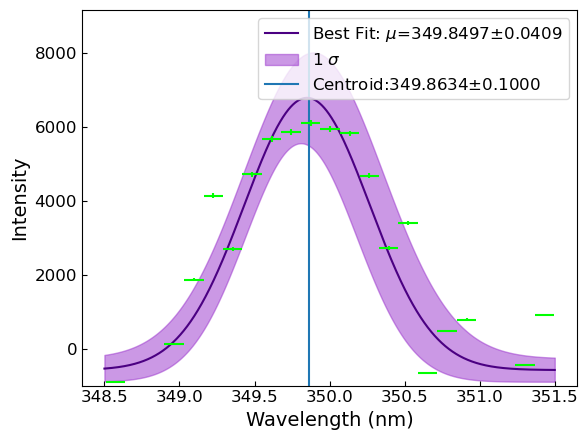

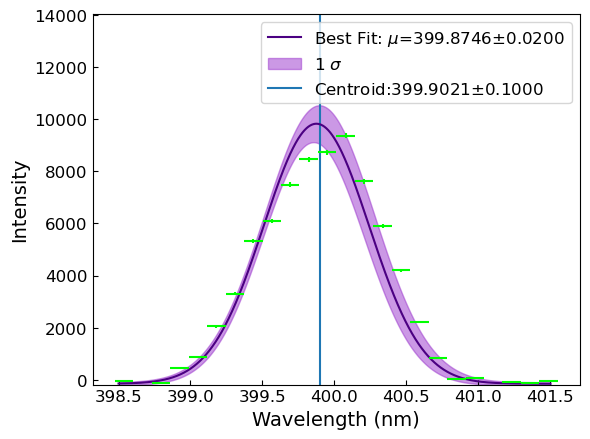

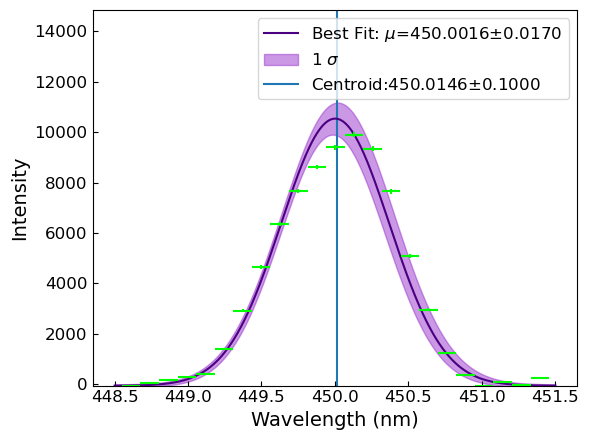

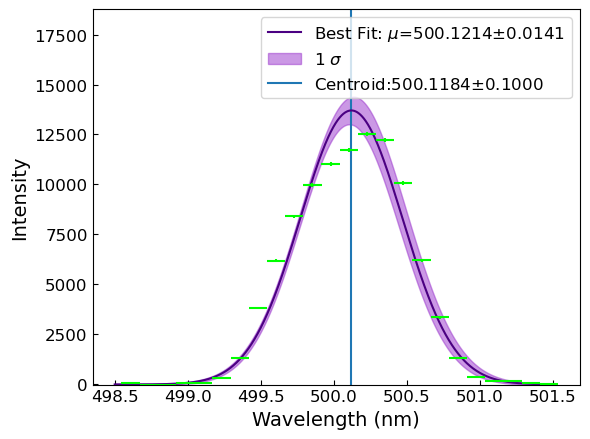

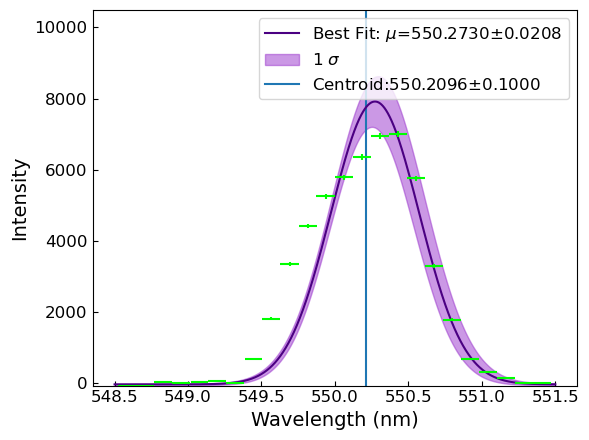

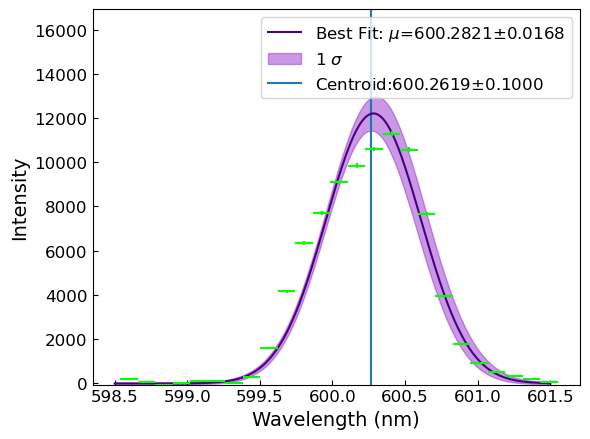

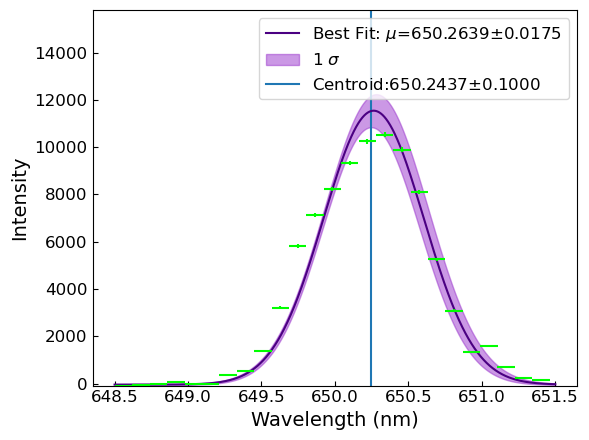

In [53]:
in_wav = []
out_wav = []
out_err = []
out_cent = []
out_cent_err = []

for i in range(300, 700, 50):
    cal_spectrum = pd.read_csv(path + '{:.0f}.csv'.format(i), header=None)
    cal_wavelength, cal_intensity = np.array(cal_spectrum[0]), np.array(cal_spectrum[1])
    
    ind = (cal_wavelength < i+1.5) & (cal_wavelength > i-1.5)
    
    cal_intensity, cal_wavelength = cal_intensity[ind], cal_wavelength[ind]
    
    cal_wavelength_err = np.append(np.diff(cal_wavelength), np.diff(cal_wavelength)[-1])/2
    cal_intensity_err = np.sqrt(abs(cal_intensity))
    
    cal_popt, cal_pcov = curve_fit(gauss, cal_wavelength, cal_intensity, p0 = (i, 0.5, 10000, 0), sigma=cal_intensity_err, absolute_sigma=False, maxfev=10000)
    cal_cerr = np.sqrt(np.diag(cal_pcov))
     
    cal_centroid = centroid(cal_wavelength, cal_intensity)
    cal_centroid_err = 0.1
    
    x = np.linspace(i-1.5, i+1.5, 10000)
    
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')

    ax.errorbar(cal_wavelength, cal_intensity, xerr=cal_wavelength_err, yerr=cal_intensity_err, color='lime', ls='', zorder=10)
    ax.plot(x, gauss(x, *cal_popt), color='indigo', label='Best Fit: $\mu$={:.4f}$\pm${:.4f}'.format(cal_popt[0], cal_cerr[0]), zorder=5)
    ax.fill_between(x, gauss(x, *(cal_popt + cal_cerr)), gauss(x, *(cal_popt - cal_cerr)), color='darkorchid', alpha=0.5, label='1 $\sigma$', zorder=0)
    ax.axvline(cal_centroid, label='Centroid:{:.4f}$\pm${:.4f}'.format(cal_centroid, cal_centroid_err))
    
    in_wav = np.append(in_wav, i)
    out_wav = np.append(out_wav, cal_popt[0])
    out_err = np.append(out_err, cal_cerr[0])
    out_cent = np.append(out_cent, cal_centroid)
    out_cent_err = np.append(out_cent_err, cal_centroid_err)
    
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')
    ax.tick_params(axis='both', direction='in', which='both')
    # ax.set_xlim(cal_popt[0] - 2.5, cal_popt[0] + 2.5)
    ax.set_ylim(0.75*cal_intensity.min(), 1.5*cal_intensity.max())
    ax.legend(loc='best')
    fig.tight_layout()

In [55]:
0.2/650*100

0.03076923076923077

## Now plot how the error changes with wavelength

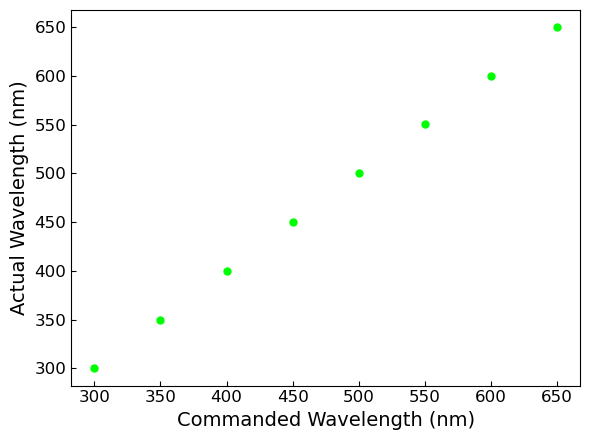

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')

ax.errorbar(in_wav, out_wav, yerr = out_err, color='lime', label='Gaussian', ls='', markersize=10, marker='.')
ax.scatter(in_wav, out_cent, color='blue', ls='', marker='.', s=10, label='Centroid')

ax.set_xlabel('Commanded Wavelength (nm)')
ax.set_ylabel('Actual Wavelength (nm)')
ax.tick_params(axis='both', direction='in', which='both')
fig.tight_layout()

### Fit this to a line
Should have a slope of exactly one and intercept of zero

In [37]:
def linear(x, m, b):
    return m * x + b

In [38]:
x = np.linspace(300, 650, 1000)

In [39]:
lin_popt, lin_pcov = curve_fit(linear, in_wav, out_wav, p0=(1, 0), sigma=out_err, absolute_sigma=False)
lin_cerr = np.sqrt(np.diag(lin_pcov))

In [40]:
lin_popt_cent, lin_pcov_cent = curve_fit(linear, in_wav, out_cent, p0=(1, 0))
lin_cerr_cent = np.sqrt(np.diag(lin_pcov_cent))

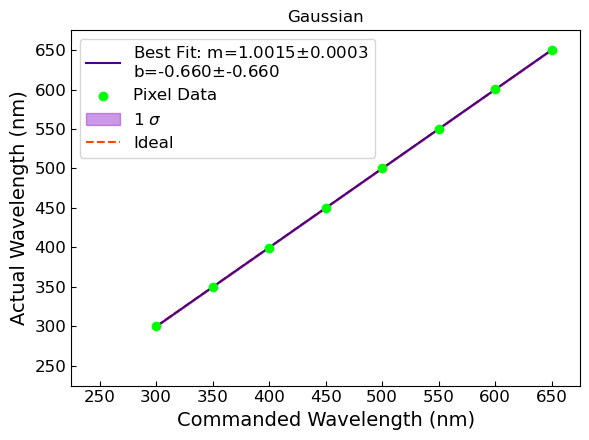

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')

ax.plot(x, linear(x, *lin_popt), color='indigo', zorder=5, label='Best Fit: m={:.4f}$\pm${:.4f}\nb={:.3f}$\pm${:.3f}'.format(lin_popt[0], lin_cerr[0], lin_popt[1], lin_popt[1]))
ax.scatter(in_wav, out_wav, color='lime', label='Pixel Data', zorder=10)
ax.fill_between(x, linear(x, *(lin_popt + lin_cerr)), linear(x, *(lin_popt - lin_cerr)), color='darkorchid', alpha=0.5, label='1 $\sigma$', zorder=0)
ax.plot(x, linear(x, 1, 0), color='orangered', zorder=0, ls='--', label='Ideal')

ax.set_xlabel('Commanded Wavelength (nm)')
ax.set_ylabel('Actual Wavelength (nm)')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(225, 675)
ax.set_ylim(225, 675)
plt.legend(loc='best')
plt.title('Gaussian')
fig.tight_layout()

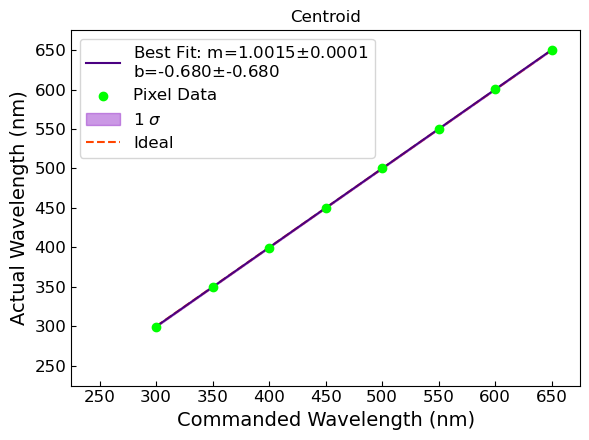

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')

ax.plot(x, linear(x, *lin_popt_cent), color='indigo', zorder=5, label='Best Fit: m={:.4f}$\pm${:.4f}\nb={:.3f}$\pm${:.3f}'.format(lin_popt_cent[0], lin_cerr_cent[0], lin_popt_cent[1], lin_popt_cent[1]))
ax.scatter(in_wav, out_cent, color='lime', label='Pixel Data', zorder=10)
ax.fill_between(x, linear(x, *(lin_popt_cent + lin_cerr_cent)), linear(x, *(lin_popt_cent - lin_cerr_cent)), color='darkorchid', alpha=0.5, label='1 $\sigma$', zorder=0)
ax.plot(x, linear(x, 1, 0), color='orangered', zorder=0, ls='--', label='Ideal')

ax.set_xlabel('Commanded Wavelength (nm)')
ax.set_ylabel('Actual Wavelength (nm)')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(225, 675)
ax.set_ylim(225, 675)
plt.legend(loc='best')
plt.title('Centroid')
fig.tight_layout()

### Try a different normalization -- testing slope, not intercept

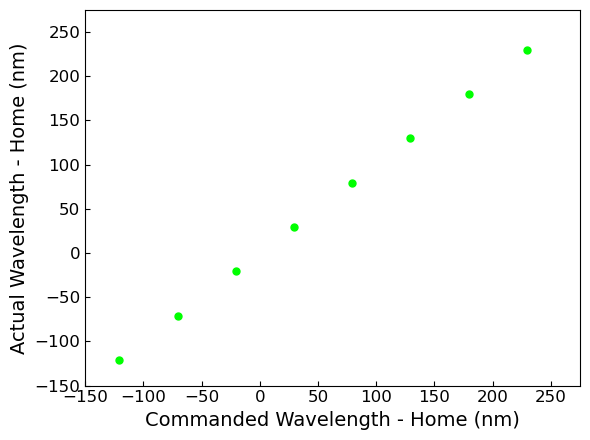

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')

in_wav_norm = in_wav - best_home_wavelength
out_wav_norm = out_wav - best_home_wavelength

ax.errorbar(in_wav_norm, out_wav_norm, yerr = out_err, color='lime', label='Pixel Data', ls='', markersize=10, marker='.')

ax.set_xlabel('Commanded Wavelength - Home (nm)')
ax.set_ylabel('Actual Wavelength - Home (nm)')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(-150, 275)
ax.set_ylim(-150, 275)
fig.tight_layout()

In [44]:
lin_popt_norm, lin_pcov_norm = curve_fit(linear, in_wav_norm, out_wav_norm, p0=(1, 0), sigma=out_err, absolute_sigma=False)
lin_cerr_norm = np.sqrt(np.diag(lin_pcov_norm))

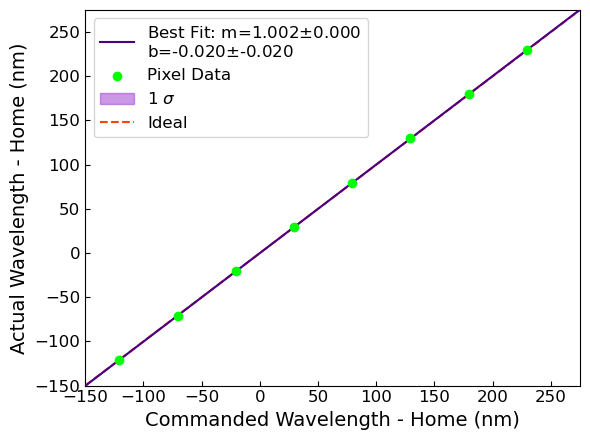

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5), layout='tight')

x = np.linspace(-200, 1000, 10000)

ax.plot(x, linear(x, *lin_popt_norm), color='indigo', zorder=5, label='Best Fit: m={:.3f}$\pm${:.3f}\nb={:.3f}$\pm${:.3f}'.format(lin_popt_norm[0], lin_cerr_norm[0], lin_popt_norm[1], lin_popt_norm[1]))
ax.scatter(in_wav_norm, out_wav_norm, color='lime', label='Pixel Data', zorder=10)
ax.fill_between(x, linear(x, *(lin_popt_norm + lin_cerr_norm)), linear(x, *(lin_popt_norm - lin_cerr_norm)), color='darkorchid', alpha=0.5, label='1 $\sigma$', zorder=0)
ax.plot(x, linear(x, 1, 0), color='orangered', zorder=0, ls='--', label='Ideal')

ax.set_xlabel('Commanded Wavelength - Home (nm)')
ax.set_ylabel('Actual Wavelength - Home (nm)')
ax.tick_params(axis='both', direction='in', which='both')
ax.set_xlim(-150, 275)
ax.set_ylim(-150, 275)
plt.legend(loc='best')
fig.tight_layout()

In [46]:
best_slope = lin_popt[0]
# best_slope_norm = lin_popt_norm[0]
print(best_slope)

1.0015216411729004


In [47]:
best_slope_cent = lin_popt_cent[0]
print(best_slope_cent)

1.0015291281426253


In [48]:
(best_slope + best_slope_cent)/2

1.001525384657763

In [49]:
9000*1.5/best_slope

13479.489054465064

In [ ]:
13479.5

In [50]:
9000*1.5

13500.0

In [52]:
1.5/(13500/13479.5)

1.497722222222222

In [54]:
(1.5-1.5/(13500/13479.5))/1.5 * 100

0.15185185185186967

In [58]:
1.4977222*9000

13479.4998

In [59]:
1.5/best_slope

1.497721006051674